In [ ]:
!nvidia-smi

Sun Jul 23 05:29:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 17.19 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls  pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.zip


In [ ]:
!ls  pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt

pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os

os.listdir(data_dir)

['train.txt', 'test.txt', 'dev.txt']

In [ ]:
filenames = [data_dir+filenames for filenames in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [ ]:
# creating a function to read filenames

def read_lines(filenames):
  with open(filenames,'r') as f:
    return f.readlines()

In [ ]:
train_lines = read_lines(filenames=data_dir+"train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_lines(filenames):
  lines = read_lines(filenames)

  abstract_lines = ""
  abstract_samples = []

  for each_line in lines:
    if each_line.startswith("###"):
      abstract_id = each_line
      abstract_lines = ""
    elif each_line.isspace():
      line_space_split = abstract_lines.splitlines()

      for line_number , line in enumerate(line_space_split):
        line_data = {}
        line_T_split = line.split("\t")

        line_data["target"] = line_T_split[0]
        line_data["text"] = line_T_split[1].lower()
        line_data["number"] = line_number
        line_data["total_num_lines"] = len(line_space_split)
        abstract_samples.append(line_data)
    else:
      abstract_lines = abstract_lines + each_line
  return abstract_samples


In [ ]:
%%time

train_data = preprocess_lines(data_dir+"train.txt")
val_data = preprocess_lines(data_dir+"dev.txt")
test_data = preprocess_lines(data_dir+"test.txt")

CPU times: user 418 ms, sys: 80.7 ms, total: 498 ms
Wall time: 501 ms


In [ ]:
train_data[:2]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'number': 0,
  'total_num_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'number': 1,
  'total_num_lines': 12}]

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

In [ ]:
train_df.head(5)

,target,text,number,total_num_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


<Axes: ylabel='Frequency'>

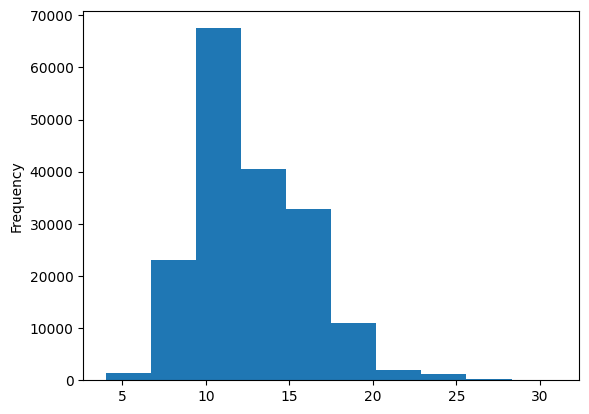

In [ ]:
import matplotlib.pyplot as mpl
train_df["total_num_lines"].plot.hist()

In [ ]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()


**now we try to convert all sentences to numbers using sklearn `oneHot`**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder(sparse=False)

train_label_encoded = one_hot.fit_transform(train_df['target'].to_numpy().reshape(-1,1))

val_label_encoded = one_hot.transform(val_df['target'].to_numpy().reshape(-1,1))

test_label_encoded = one_hot.transform(test_df['target'].to_numpy().reshape(-1,1))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


*now we use `LABEL ENCODER`to encode our above label column (target) to integers*

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_label_encoded_int = label_encoder.fit_transform(train_df['target'].to_numpy())

val_label_encoded_int = label_encoder.transform(val_df['target'].to_numpy())

test_label_encoded_int = label_encoder.transform(test_df['target'].to_numpy())

In [ ]:
# to see label names and its total number

num_of_labels = len(label_encoder.classes_)
label_names =  label_encoder.classes_

print(num_of_labels,label_names)

5 ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


**MODEL 0 (BASELINE MODEL)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
model_0 = Pipeline([
    ("vector",TfidfVectorizer()),
    ("model",MultinomialNB())
])

model_0.fit(train_sentences,train_label_encoded_int)


Pipeline(steps=[('vector', TfidfVectorizer()), ('model', MultinomialNB())])

In [ ]:
model_0.score(val_sentences,val_label_encoded_int)

0.7218323844829869

In [ ]:
model_0_preds=model_0.predict(val_sentences)

In [ ]:
from sklearn.metrics import accuracy_score , precision_score

In [ ]:
accuracy_score(model_0_preds,val_label_encoded_int)

0.7218323844829869

In [ ]:
precision_score(model_0_preds,val_label_encoded_int,average="macro")

0.5878501847023443

*NOW WE USE EMBEDDING AND TEXT VECTOR TOKENISATION TO CONVERT OUR TEXT INTO NUMBERS*

In [ ]:
# to calculate the length of each sentense
import numpy as np

sentense_len = [len(sentense.split()) for sentense in train_sentences]
average_len = np.mean(sentense_len)
average_len

26.338269273494777

In [ ]:
all_sentence_max_length = int(np.percentile(sentense_len,95))
all_sentence_max_length

55

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:




text_vector = TextVectorization(max_tokens=68000,output_sequence_length=60)

In [ ]:
text_vector.adapt(train_sentences)

In [ ]:
import random

random_sentence = random.choice(train_sentences)

print(f"random sentense {random_sentence}\n")
print(f"sentense after text vectorization {text_vector([random_sentence])}")

random sentense this was a randomised controlled study in @ frail inpatients ( in @ ) .

sentense after text vectorization [[  23   10    8  210  106   17    5 5999 3817    5    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [ ]:
text_vocal = text_vector.get_vocabulary()

print(f"most comman words {text_vocal[:10]}")
print(f"{len(text_vocal)}")

most comman words ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
64841


In [ ]:
text_vector.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 60,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [ ]:
import tensorflow as tf

# now we create our embedding layer

emb_layer = tf.keras.layers.Embedding(input_dim=68000,output_dim=128,mask_zero=True)

In [ ]:

print(f"random sentense {random_sentence}\n")
print(f"sentense after text vectorization {text_vector([random_sentence])}")
print(f"sentense after text embeding\n")
print(emb_layer(text_vector([random_sentence])))
print(f"text shape {emb_layer(text_vector([random_sentence])).shape}")

random sentense this was a randomised controlled study in @ frail inpatients ( in @ ) .

sentense after text vectorization [[  23   10    8  210  106   17    5 5999 3817    5    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]
sentense after text embeding

tf.Tensor(
[[[ 0.0171364   0.00322754 -0.02614298 ...  0.02033159  0.01437365
   -0.03657899]
  [ 0.02249786  0.01806566 -0.00403378 ...  0.01958449  0.0363376
    0.03665039]
  [ 0.02227223 -0.00222002  0.0200556  ... -0.01889789  0.04302771
   -0.04472107]
  ...
  [ 0.04903788  0.03937843 -0.03322144 ... -0.01129693 -0.01082037
    0.04325822]
  [ 0.04903788  0.03937843 -0.03322144 ... -0.01129693 -0.01082037
    0.04325822]
  [ 0.04903788  0.03937843 -0.03322144 ... -0.01129693 -0.01082037
    0.04325822]]], shape=(1, 60, 128)

**now we create Dataset using tf.data**

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_label_encoded))

val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences ,val_label_encoded))

test_dataset = tf.data.Dataset.from_tensor_slices(( test_sentences ,test_label_encoded))

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

**NOW WE TRY OUR SECOND MODEL CONVOLUTION MODEL**

In [ ]:
inputs = tf.keras.Input(shape=(1,),dtype="string")

text_vectors = text_vector(inputs)

emb = emb_layer(text_vectors)

x = tf.keras.layers.Conv1D(filters=64,kernel_size=8,padding="same",activation="relu") (emb)

x = tf.keras.layers.GlobalAvgPool1D()(x)

outputs = tf.keras.layers.Dense(5,activation="softmax") (x)

model_1 = tf.keras.Model(inputs,outputs)

In [ ]:
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=tf.keras.metrics.Accuracy())

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 60)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 60, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 60, 64)            65600     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
tbc = tf.keras.callbacks.TensorBoard(log_dir="tbc")


In [ ]:
history_1 = model_1.fit(train_dataset,epochs=3,steps_per_epoch=int((0.2*len(train_dataset))),validation_data=val_dataset,validation_steps=int(0.2*len(val_dataset)),callbacks=[tbc])

Epoch 1/3
1125/1125 [==============================] - 50s 36ms/step - loss: 0.7842 - accuracy: 1.2778e-04 - val_loss: 0.6405 - val_accuracy: 6.6138e-05
Epoch 2/3
1125/1125 [==============================] - 11s 10ms/step - loss: 0.6024 - accuracy: 4.3889e-04 - val_loss: 0.5665 - val_accuracy: 1.9841e-04
Epoch 3/3
1125/1125 [==============================] - 11s 10ms/step - loss: 0.5803 - accuracy: 3.8889e-04 - val_loss: 0.5364 - val_accuracy: 1.6534e-04


In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5422 - accuracy: 3.1113e-04


[0.5422238707542419, 0.00031113464501686394]

In [ ]:
model_1_preds = model_1.predict(val_dataset)
model_1_preds

945/945 [==============================] - 2s 2ms/step


array([[5.6168699e-01, 1.7098467e-01, 3.0597018e-02, 1.8451841e-01,
        5.2212853e-02],
       [5.9040463e-01, 1.8563771e-01, 1.2842112e-02, 1.9056393e-01,
        2.0551702e-02],
       [2.4167377e-01, 4.1179592e-03, 1.0280156e-04, 7.5409043e-01,
        1.5046551e-05],
       ...,
       [2.4680179e-05, 3.1925170e-04, 3.5596136e-03, 1.5798279e-05,
        9.9608070e-01],
       [2.9658571e-01, 2.6953098e-01, 9.1962717e-02, 1.4866292e-01,
        1.9325759e-01],
       [8.0937251e-02, 8.5312670e-01, 3.7966494e-02, 6.7286692e-03,
        2.1240899e-02]], dtype=float32)

In [ ]:
model_1_pred_classes = tf.argmax(model_1_preds,axis=1)
model_1_pred_classes

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 0, 1])>

**NOW WE CAME TO 2nd MODEL OUR FEATURE EXTRACTOR AND PRETRAINED MODEL**

In [ ]:
import tensorflow_hub as hub
hub_model = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable=False)


In [ ]:
random_sentense = random.choice(train_sentences)
print(f"our text {random_sentense}\n")
print(f"converted to hub layer encoder{hub_model([random_sentense])}\n")
print(f"len of each sentense {hub_model([random_sentense]).shape}")


our text the extended-release formulation of quetiapine ( quetiapine xr ) , which was developed to provide more convenient once-daily administration , has been widely studied to characterize its pharmacokinetics in caucasian populations but has rarely been studied in an asia population .

converted to hub layer encoder[[-7.29183927e-02  6.24767058e-02 -2.10574325e-02 -5.15416786e-02
  -1.59028508e-02  7.47298300e-02  3.92152667e-02 -2.27420591e-03
   2.71585155e-02 -1.15752434e-02  5.71221523e-02  3.30412723e-02
   7.88612738e-02  2.08023507e-02  2.97896769e-02  2.55759303e-02
  -6.06225021e-02  6.17756546e-02 -4.22803015e-02 -6.30316585e-02
  -7.59818032e-02 -3.72780487e-02 -4.29459289e-02  4.15542349e-03
   3.62447985e-02  5.61322793e-02  7.28673413e-02  1.02833081e-02
  -5.40571660e-02 -5.59909418e-02  7.46258050e-02  8.54560286e-02
   5.55113016e-04 -1.39212450e-02 -1.85893588e-02 -1.27356616e-04
  -6.75543472e-02 -3.08261439e-03 -5.66171333e-02  9.49408335e-04
  -1.93867143e-02  7

In [ ]:
inputs = tf.keras.Input(shape=(),dtype=tf.string)

pretrained_emb = hub_model(inputs)


x = tf.keras.layers.Dense(64,activation="relu") (pretrained_emb)



outputs = tf.keras.layers.Dense(5,activation="softmax") (x)

model_2 = tf.keras.Model(inputs,outputs)


In [ ]:
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics="accuracy")

In [ ]:
history_2 = model_2.fit(train_dataset,epochs=3,steps_per_epoch=int((0.2*len(train_dataset))),validation_data=val_dataset,validation_steps=int(0.2*len(val_dataset)),callbacks=[tbc])

Epoch 1/3
1125/1125 [==============================] - 20s 15ms/step - loss: 0.8741 - accuracy: 0.6650 - val_loss: 0.7674 - val_accuracy: 0.7025
Epoch 2/3
1125/1125 [==============================] - 15s 14ms/step - loss: 0.7540 - accuracy: 0.7106 - val_loss: 0.7396 - val_accuracy: 0.7174
Epoch 3/3
1125/1125 [==============================] - 16s 14ms/step - loss: 0.7484 - accuracy: 0.7148 - val_loss: 0.7106 - val_accuracy: 0.7307


In [ ]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7129 - accuracy: 0.7274


[0.7129324078559875, 0.7273930907249451]

In [ ]:
model_2_preds = model_2.predict(val_dataset)

945/945 [==============================] - 10s 11ms/step


In [ ]:
model_2_pred_classes = tf.argmax(model_2_preds,axis=1)
model_2_pred_classes

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

**NOW WE CREATE MODEL 3 WITH CHARACTER EMBEDDING**

*FIRST WE CREATE CHARACTER LEVEL TOKENIZER*

In [ ]:
list("".join(train_sentences[0]))

['t',
 'o',
 ' ',
 'i',
 'n',
 'v',
 'e',
 's',
 't',
 'i',
 'g',
 'a',
 't',
 'e',
 ' ',
 't',
 'h',
 'e',
 ' ',
 'e',
 'f',
 'f',
 'i',
 'c',
 'a',
 'c',
 'y',
 ' ',
 'o',
 'f',
 ' ',
 '@',
 ' ',
 'w',
 'e',
 'e',
 'k',
 's',
 ' ',
 'o',
 'f',
 ' ',
 'd',
 'a',
 'i',
 'l',
 'y',
 ' ',
 'l',
 'o',
 'w',
 '-',
 'd',
 'o',
 's',
 'e',
 ' ',
 'o',
 'r',
 'a',
 'l',
 ' ',
 'p',
 'r',
 'e',
 'd',
 'n',
 'i',
 's',
 'o',
 'l',
 'o',
 'n',
 'e',
 ' ',
 'i',
 'n',
 ' ',
 'i',
 'm',
 'p',
 'r',
 'o',
 'v',
 'i',
 'n',
 'g',
 ' ',
 'p',
 'a',
 'i',
 'n',
 ' ',
 ',',
 ' ',
 'm',
 'o',
 'b',
 'i',
 'l',
 'i',
 't',
 'y',
 ' ',
 ',',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 's',
 'y',
 's',
 't',
 'e',
 'm',
 'i',
 'c',
 ' ',
 'l',
 'o',
 'w',
 '-',
 'g',
 'r',
 'a',
 'd',
 'e',
 ' ',
 'i',
 'n',
 'f',
 'l',
 'a',
 'm',
 'm',
 'a',
 't',
 'i',
 'o',
 'n',
 ' ',
 'i',
 'n',
 ' ',
 't',
 'h',
 'e',
 ' ',
 's',
 'h',
 'o',
 'r',
 't',
 ' ',
 't',
 'e',
 'r',
 'm',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'w',
 'h',
 'e'

In [ ]:
def char_tokeniser(sentences):
  return " ".join(list(sentences))


char_tokeniser(random_sentence)

't h i s   w a s   a   r a n d o m i s e d   c o n t r o l l e d   s t u d y   i n   @   f r a i l   i n p a t i e n t s   (   i n   @   )   .'

In [ ]:
# now we apply this for our train,val,test sentenses

train_chars = [char_tokeniser(sentense) for sentense in train_sentences]

val_chars = [char_tokeniser(sentense) for sentense in val_sentences]

test_chars = [char_tokeniser(sentense) for sentense in test_sentences]

In [ ]:
# now we calculate average character length

char_len = [len(sentense) for sentense in train_sentences]

avg_char_len = np.mean(char_len)

avg_char_len

149.3662574983337

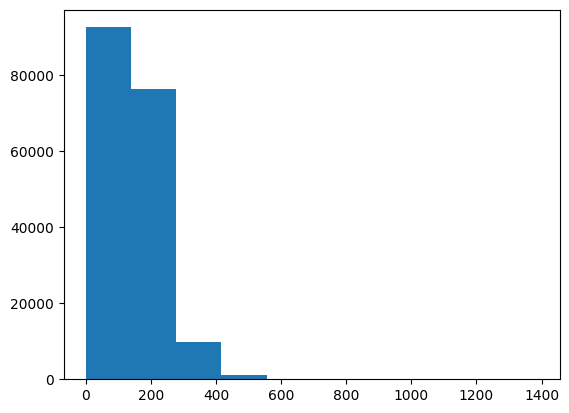

In [ ]:
mpl.hist(char_len);


In [ ]:
max_percentile = int(np.percentile(char_len,95))
max_percentile

290

*now we use our textvector to tokenise this above characters*

In [ ]:
import string

alphabet = string.ascii_lowercase+string.digits+string.punctuation

print(alphabet) , len(alphabet)

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


(None, 68)

In [ ]:
character_to_text_vector = TextVectorization(max_tokens=len(alphabet)+2,output_sequence_length=300)

In [ ]:
character_to_text_vector.adapt(train_chars)

In [ ]:
random_train_chars = random.choice(train_chars)

print(f"text before vector-> {random_train_chars}\n")
print(f"text after vector-> {character_to_text_vector(random_train_chars)}\n")

text before vector-> t h e   h i g h   c o n c o r d a n c e   ,   s p e c i f i c i t y   ,   a n d   s e n s i t i v i t y   d e m o n s t r a t e   t h a t   e g f r   m u t a t i o n   s t a t u s   c a n   b e   a c c u r a t e l y   a s s e s s e d   u s i n g   c i r c u l a t i n g - f r e e   t u m o r   d n a   .

text after vector-> [ 3 13  2 13  4 18 13 11  7  6 11  7  8 10  5  6 11  2  9 14  2 11  4 17
  4 11  4  3 19  5  6 10  9  2  6  9  4  3  4 21  4  3 19 10  2 15  7  6
  9  3  8  5  3  2  3 13  5  3  2 18 17  8 15 16  3  5  3  4  7  6  9  3
  5  3 16  9 11  5  6 22  2  5 11 11 16  8  5  3  2 12 19  5  9  9  2  9
  9  2 10 16  9  4  6 18 11  4  8 11 16 12  5  3  4  6 18 17  8  2  2  3
 16 15  7  8 10  6  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [ ]:
# get vocal

char_vocab =character_to_text_vector.get_vocabulary()

*Now we convert our text vector in embeded form*

In [ ]:
char_emb = tf.keras.layers.Embedding(input_dim=len(char_vocab),output_dim=30,mask_zero=True)

In [ ]:
print(f"normal characters \n {random_train_chars}\n")

print(f"characters after text vector\n {character_to_text_vector(random_train_chars)}\n")

char_emb_display = char_emb(character_to_text_vector([random_train_chars]))

print(f"characters after embedding\n {char_emb(character_to_text_vector([random_train_chars]))}")

print(f"shape \n {char_emb_display.shape}")

normal characters 
 t h e   h i g h   c o n c o r d a n c e   ,   s p e c i f i c i t y   ,   a n d   s e n s i t i v i t y   d e m o n s t r a t e   t h a t   e g f r   m u t a t i o n   s t a t u s   c a n   b e   a c c u r a t e l y   a s s e s s e d   u s i n g   c i r c u l a t i n g - f r e e   t u m o r   d n a   .

characters after text vector
 [ 3 13  2 13  4 18 13 11  7  6 11  7  8 10  5  6 11  2  9 14  2 11  4 17
  4 11  4  3 19  5  6 10  9  2  6  9  4  3  4 21  4  3 19 10  2 15  7  6
  9  3  8  5  3  2  3 13  5  3  2 18 17  8 15 16  3  5  3  4  7  6  9  3
  5  3 16  9 11  5  6 22  2  5 11 11 16  8  5  3  2 12 19  5  9  9  2  9
  9  2 10 16  9  4  6 18 11  4  8 11 16 12  5  3  4  6 18 17  8  2  2  3
 16 15  7  8 10  6  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

**NOW WE CREATE OUR MODEL 3 WITH CHARACTER EMBEDDING**

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,),dtype="string")

text_vector = character_to_text_vector(inputs)

character_emb = char_emb(text_vector)

x= tf.keras.layers.Conv1D(filters=64,kernel_size=4,padding="valid",activation="relu") (character_emb)

x = tf.keras.layers.GlobalMaxPooling1D()(x)

outputs = tf.keras.layers.Dense(5,activation="softmax")(x)

model_3 = tf.keras.Model(inputs,outputs)

In [ ]:
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics="accuracy")

In [ ]:
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_label_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
val_chars_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_label_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_label_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_3 = model_3.fit(train_chars_dataset,epochs=3,steps_per_epoch=int((0.2*len(train_chars_dataset))),validation_data=val_chars_dataset,validation_steps=int(0.2*len(val_chars_dataset)),callbacks=[tbc])

Epoch 1/3
1125/1125 [==============================] - 10s 7ms/step - loss: 1.1677 - accuracy: 0.5277 - val_loss: 0.9739 - val_accuracy: 0.6233
Epoch 2/3
1125/1125 [==============================] - 6s 5ms/step - loss: 0.9213 - accuracy: 0.6394 - val_loss: 0.8589 - val_accuracy: 0.6711
Epoch 3/3
1125/1125 [==============================] - 7s 6ms/step - loss: 0.8674 - accuracy: 0.6635 - val_loss: 0.8235 - val_accuracy: 0.6786


In [ ]:
model_3.evaluate(val_chars_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8372 - accuracy: 0.6749


[0.8372312784194946, 0.6748642921447754]

In [ ]:
model_3_preds = model_3.predict(val_chars_dataset)

945/945 [==============================] - 2s 2ms/step


In [ ]:
model_3_pred_classes = tf.argmax(model_3_preds,axis=1)
model_3_pred_classes

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 3, 3, ..., 4, 2, 1])>

**NOW WE COMBINE 2 MODELS (EARLIER MODELS) USING CONCATENATION AND CREATE A NEW MODEL 4**

In [ ]:
token_inputs = tf.keras.layers.Input(shape=[],dtype="string")

token_emb_inputs = hub_model(token_inputs)

token_outputs  = tf.keras.layers.Dense(128,activation="relu") (token_emb_inputs)

token_model = tf.keras.Model(token_inputs,token_outputs)



char_inputs = tf.keras.layers.Input(shape=(1,),dtype="string")

char_vector = character_to_text_vector(char_inputs)

char_embd =  char_emb(char_vector)

char_bi_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embd)

char_model = tf.keras.Model(char_inputs,char_bi_layer)


model_concatenate = tf.keras.layers.Concatenate()([token_model.output,char_model.output])



dropout = tf.keras.layers.Dropout(0.5)(model_concatenate)

dense_layer = tf.keras.layers.Dense(200,activation="relu") (dropout)

final_dropout = tf.keras.layers.Dropout(0.5)(dense_layer)

final_outputs = tf.keras.layers.Dense(5,activation="softmax") (final_dropout)

model_4 = tf.keras.Model(inputs = [token_model.input,char_model.input],outputs = final_outputs)

In [ ]:
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 300)         0           ['input_5[0][0]']                
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['input_4[0][0]']          

In [ ]:
from keras.utils import plot_model

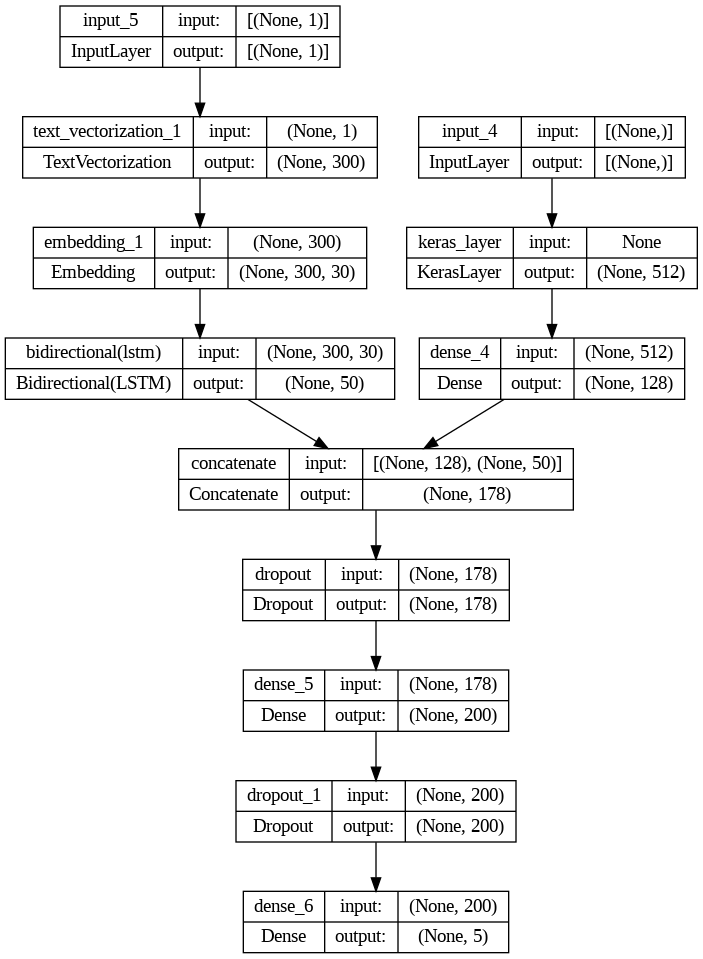

In [ ]:
plot_model(model_4,show_shapes=True)

In [ ]:
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
# now we create datasets
# this is train datasets

token_train_datasets = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
token_label_datasets = tf.data.Dataset.from_tensor_slices(train_label_encoded)

combine_train_datasets = tf.data.Dataset.zip((token_train_datasets,token_label_datasets))

combine_train_datasets = combine_train_datasets.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# this is validation datasets

token_val_datasets = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
token_label_datasets = tf.data.Dataset.from_tensor_slices(val_label_encoded)

combine_val_datasets = tf.data.Dataset.zip((token_val_datasets,token_label_datasets))

combine_val_datasets = combine_val_datasets.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# this is for test datasets


token_test_datasets = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
token_label_datasets = tf.data.Dataset.from_tensor_slices(test_label_encoded)

combine_test_datasets = tf.data.Dataset.zip((token_test_datasets,token_label_datasets))

combine_test_datasets_prefetch = combine_test_datasets.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:


combine_train_datasets,combine_val_datasets

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
model_4_history = model_4.fit(combine_train_datasets,
                              steps_per_epoch=int(0.1 * len(combine_train_datasets)),
                              epochs=3,validation_data=combine_val_datasets,
                              validation_steps=int(0.1 * len(combine_val_datasets)))

Epoch 1/3
562/562 [==============================] - 42s 54ms/step - loss: 0.9661 - accuracy: 0.6163 - val_loss: 0.7753 - val_accuracy: 0.7035
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.7872 - accuracy: 0.6944 - val_loss: 0.7147 - val_accuracy: 0.7320
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.7689 - accuracy: 0.7066 - val_loss: 0.6934 - val_accuracy: 0.7384


In [ ]:
model_4.evaluate(combine_val_datasets)

945/945 [==============================] - 21s 22ms/step - loss: 0.6986 - accuracy: 0.7344


[0.698610246181488, 0.7344432473182678]

In [ ]:
model_4_preds = model_4.predict(combine_val_datasets)

945/945 [==============================] - 21s 20ms/step


In [ ]:
model_4_pred_classes = tf.argmax(model_4_preds,axis=1)
model_4_pred_classes

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
!nvidia-smi

Sun Jul 23 05:40:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    34W /  70W |   3319MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
train_df.head(10)

,target,text,number,total_num_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12
6,RESULTS,there was a clinically relevant reduction in t...,6,12
7,RESULTS,the mean difference between treatment arms ( @...,7,12
8,RESULTS,"further , there was a clinically relevant redu...",8,12
9,RESULTS,these differences remained significant at @ we...,9,12


In [ ]:
train_df.number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: number, dtype: int64

<Axes: ylabel='Frequency'>

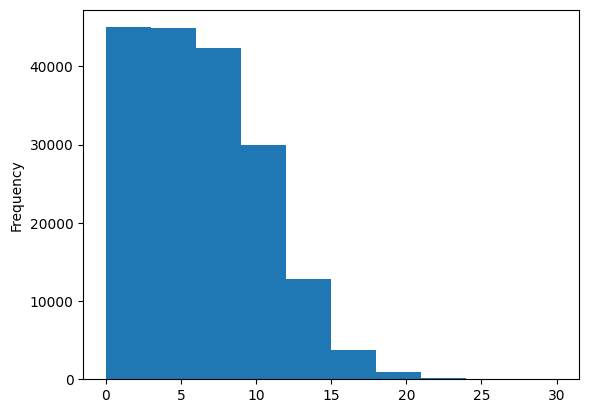

In [ ]:
train_df.number.plot.hist()

In [ ]:
train_line_number_encoded = tf.one_hot(train_df["number"].to_numpy(),depth=13)
test_line_number_encoded = tf.one_hot(test_df["number"].to_numpy(),depth=13)
val_line_number_encoded = tf.one_hot(val_df["number"].to_numpy(),depth=13)

train_line_number_encoded.shape

TensorShape([180040, 13])

In [ ]:
np.percentile(train_df["number"],95)

13.0

In [ ]:
train_df.total_num_lines.value_counts()

12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: total_num_lines, dtype: int64

In [ ]:
np.percentile(train_df.total_num_lines,95)

19.0

<Axes: ylabel='Frequency'>

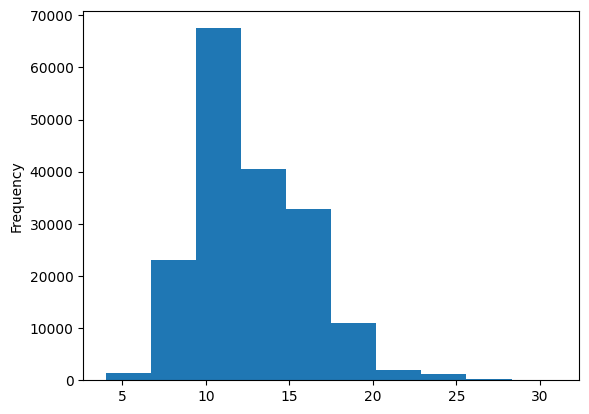

In [ ]:
train_df.total_num_lines.plot.hist()

In [ ]:
train_total_line_encoded = tf.one_hot(train_df.total_num_lines.to_numpy(),19)
val_total_line_encoded = tf.one_hot(val_df.total_num_lines.to_numpy(),19)
test_total_line_encoded = tf.one_hot(test_df.total_num_lines.to_numpy(),19)

train_total_line_encoded.shape

TensorShape([180040, 19])

**NOW WE START BUILDING TRI EMBEDED MODEL**

In [ ]:
token_inputs = tf.keras.Input(shape=[],dtype=tf.string)

token_emb = hub_model(token_inputs)

token_outputs  = tf.keras.layers.Dense(128,activation="relu")(token_emb)

token_model = tf.keras.Model(token_inputs,token_outputs)



char_inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)

char_token = character_to_text_vector(char_inputs)

char_emb = emb_layer(char_token)

char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)) (char_emb)

char_model = tf.keras.Model(char_inputs,char_bi_lstm)



line_input = tf.keras.layers.Input(shape=(13,),dtype=tf.float32)

line_output = tf.keras.layers.Dense(32,activation="relu")(line_input)

line_model = tf.keras.Model(line_input,line_output)


total_line_input = tf.keras.layers.Input(shape=(19,),dtype=tf.float32)

total_line_output = tf.keras.layers.Dense(32,activation="relu")(total_line_input)

total_line_model = tf.keras.Model(total_line_input,total_line_output)



combine_embeded_model = tf.keras.layers.Concatenate()([token_model.output,char_model.output])

layer_1 = tf.keras.layers.Dense(256,activation="relu") (combine_embeded_model )

dropout_layer = tf.keras.layers.Dropout(0.5)(layer_1)

combined_tri_model = tf.keras.layers.Concatenate()([line_model.output,total_line_model.output,dropout_layer])


final_output_layer = tf.keras.layers.Dense(5,activation="softmax")(combined_tri_model)

model_5 = tf.keras.Model([token_model.input,char_model.input,line_model.input,total_line_model.input],final_output_layer)

In [ ]:
model_5.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 300)         0           ['input_7[0][0]']                
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['input_6[0][0]']         

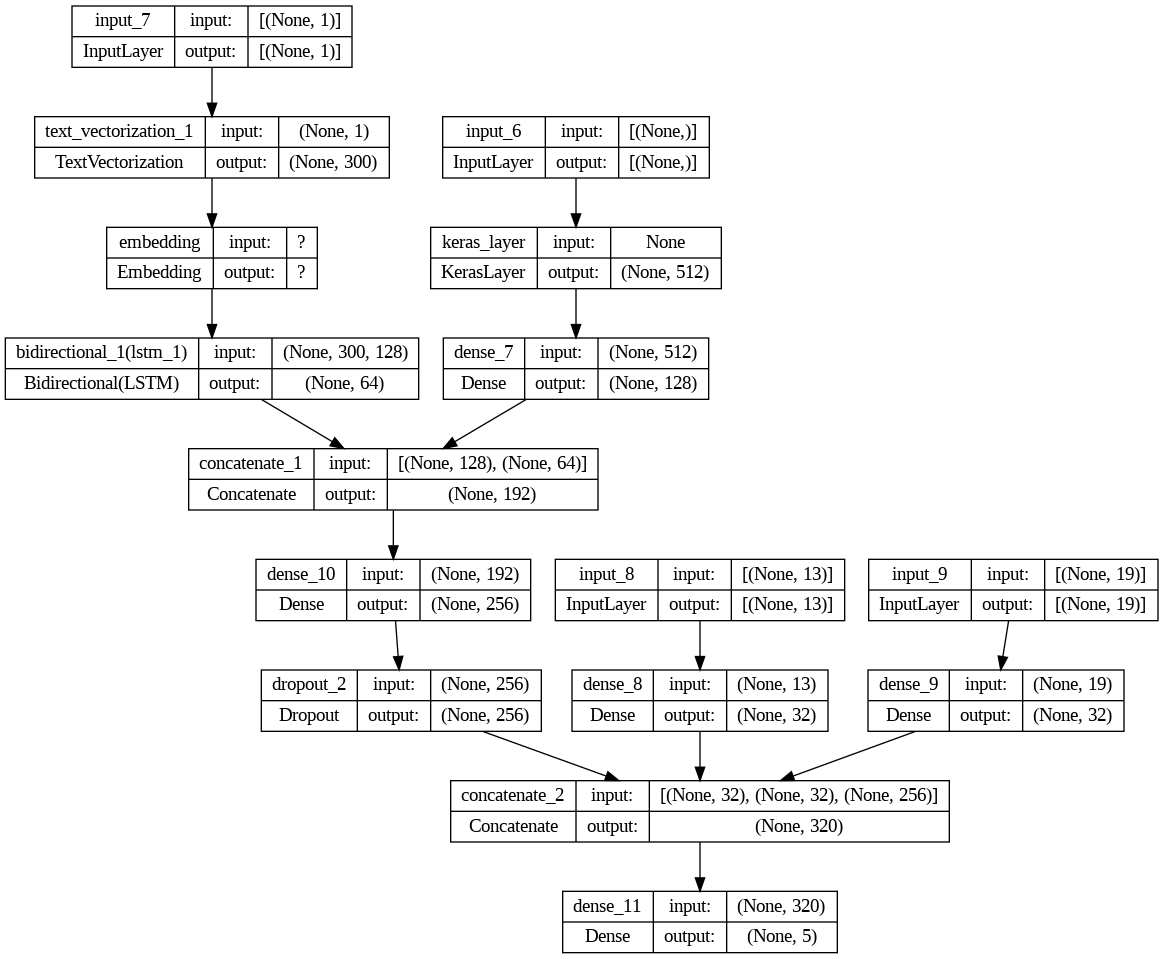

In [ ]:
from keras.utils import plot_model
plot_model(model_5,show_shapes=True)

In [ ]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),optimizer=tf.keras.optimizers.SGD(),metrics=["accuracy"])

*NOW WE CREATE DATASET FOR OUR TRI MODEL5*

In [ ]:
train_model_5_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars,train_line_number_encoded,train_total_line_encoded))

train_model_5_label = tf.data.Dataset.from_tensor_slices(train_label_encoded)

train_model_5_dataset = tf.data.Dataset.zip((train_model_5_data,train_model_5_label))

train_model_5_prefetch = train_model_5_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_model_5_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars,val_line_number_encoded,val_total_line_encoded))

val_model_5_label = tf.data.Dataset.from_tensor_slices(val_label_encoded)

val_model_5_dataset = tf.data.Dataset.zip((val_model_5_data,val_model_5_label))

val_model_5_prefetch = val_model_5_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_model_5_prefetch ,val_model_5_prefetch

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 19), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 19), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_5 = model_5.fit(train_model_5_prefetch,
                        epochs=5,
                        steps_per_epoch=int(0.1*len(train_model_5_prefetch)),
                        validation_data=val_model_5_prefetch,
                        validation_steps=int(0.1*len(val_model_5_prefetch)),
                        callbacks=[tbc])

Epoch 1/5
562/562 [==============================] - 40s 55ms/step - loss: 1.5246 - accuracy: 0.3697 - val_loss: 1.4838 - val_accuracy: 0.4461
Epoch 2/5
562/562 [==============================] - 28s 51ms/step - loss: 1.4583 - accuracy: 0.4706 - val_loss: 1.4303 - val_accuracy: 0.5110
Epoch 3/5
562/562 [==============================] - 26s 47ms/step - loss: 1.4022 - accuracy: 0.5076 - val_loss: 1.3660 - val_accuracy: 0.5283
Epoch 4/5
562/562 [==============================] - 29s 52ms/step - loss: 1.3300 - accuracy: 0.5416 - val_loss: 1.2959 - val_accuracy: 0.5735
Epoch 5/5
562/562 [==============================] - 27s 48ms/step - loss: 1.2666 - accuracy: 0.6014 - val_loss: 1.2316 - val_accuracy: 0.6439


In [ ]:
model_5.evaluate(val_model_5_prefetch)

945/945 [==============================] - 21s 22ms/step - loss: 1.2268 - accuracy: 0.6414


[1.2268470525741577, 0.6414338946342468]

**NOW WE SAVE AND LOAD OUR MODEL**

In [ ]:
model_5.save("skimlim_model")

In [ ]:


!tensorboard dev upload --logdir tbc/ --name "skimlim_model"

2023-07-23 05:45:47.316253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

tbc/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/pyth

In [ ]:
test_model_5_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars,test_line_number_encoded,test_total_line_encoded))
test_model_5_label = tf.data.Dataset.from_tensor_slices(test_label_encoded)
test_model_5_dataset = tf.data.Dataset.zip((test_model_5_data,test_model_5_label ))

test_model_5_prefetch = test_model_5_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_model_5_prefetch

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 19), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
test_predictions = model_5.predict(test_model_5_prefetch)
test_predictions

942/942 [==============================] - 20s 21ms/step


array([[0.29472008, 0.16588207, 0.2003303 , 0.22179106, 0.11727649],
       [0.2695338 , 0.15108533, 0.28291026, 0.15264197, 0.14382868],
       [0.12425939, 0.11599394, 0.4700158 , 0.07947516, 0.2102557 ],
       ...,
       [0.12591526, 0.20561625, 0.24187979, 0.09632324, 0.3302655 ],
       [0.11027379, 0.19564012, 0.25912458, 0.0862283 , 0.34873325],
       [0.12076693, 0.21327588, 0.35000396, 0.08200662, 0.23394659]],
      dtype=float32)

In [ ]:
model_5_test_pred_classes = tf.argmax(test_predictions,axis=1)
model_5_test_pred_classes[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 2, 2, 2, 4, 4, 4, 2, 4, 0])>

<Axes: >

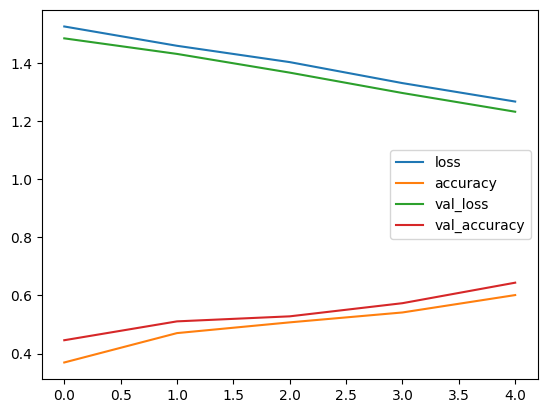

In [ ]:
pd.DataFrame(history_5.history).plot()

**FINDING MOST WRONG**

In [ ]:
model_5_predicts =label_names[model_5_test_pred_classes]
model_5_predicts

array(['BACKGROUND', 'METHODS', 'METHODS', ..., 'RESULTS', 'RESULTS',
       'METHODS'], dtype=object)

In [ ]:
test_pred_classes = [label_encoder.classes_[p] for p in model_5_test_pred_classes]
test_pred_classes[:10]

['BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'BACKGROUND']

In [ ]:
test_df.head(10)

,target,text,number,total_num_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,9
1,RESULTS,a post hoc analysis was conducted with the use...,1,9
2,RESULTS,liver function tests ( lfts ) were measured at...,2,9
3,RESULTS,survival analyses were used to assess the asso...,3,9
4,RESULTS,the percentage of patients with abnormal lfts ...,4,9
5,RESULTS,when mean hemodynamic profiles were compared i...,5,9
6,RESULTS,multivariable analyses revealed that patients ...,6,9
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,9
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,9
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,13


In [ ]:
tf.reduce_max(test_predictions,axis=1)

<tf.Tensor: shape=(30135,), dtype=float32, numpy=
array([0.29472008, 0.28291026, 0.4700158 , ..., 0.3302655 , 0.34873325,
       0.35000396], dtype=float32)>

In [ ]:
test_df["prediction_classes"] = test_pred_classes
test_df["predictions"] = tf.reduce_max(test_predictions,axis=1)
test_df["is_correct"] = test_df["predictions"] ==test_df["target"]

<Axes: >

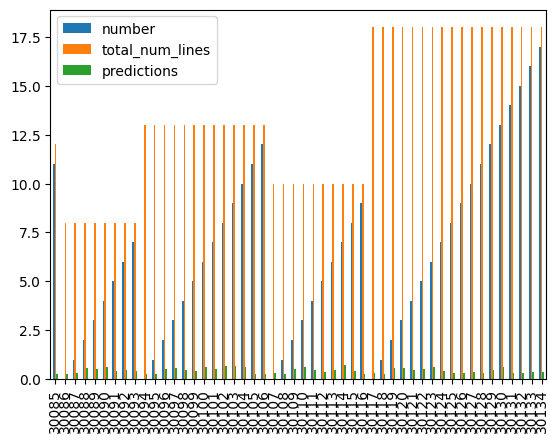

In [ ]:
test_df.tail(50).plot.bar()